For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [6]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,25):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [7]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [8]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [9]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [10]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [11]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# Added by David:
# 4a. Create dictionary of road-pixel matrices

In [12]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


KeyboardInterrupt: 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


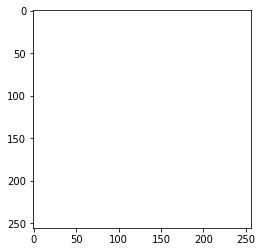

(256, 256, 3)
<class 'numpy.ndarray'>


In [12]:
# DK checks
image = "95000_430000_95200_430200.jpg"
filename = INPUT_FOLDER_TILES + image
image_view = ndimage.imread(filename).astype(np.float32)
plt.imshow(image_view)
plt.show()
print(image_view.shape)
print(type(image_view))


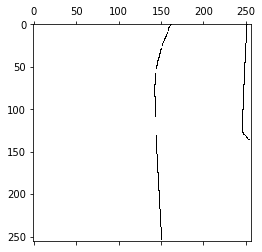

In [9]:
image = "95000_430000_95200_430200.jpg"
test_matrix = d_road_pixels[image]
plt.spy(test_matrix)
plt.show()

In [ ]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [13]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

Of roadtype G (Gemeente) there are 4963 tiles.
Of roadtype W (Waterschap) there are 915 tiles.
Of roadtype P (Provincie) there are 48 tiles.
Of roadtype T (Andere wegbeheerder) there are 1 tiles.


# 5. Prepare dataset for CNN

In [51]:
def randomize(dataset, labels1, labels2):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    print(labels2.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation, :]
    randomized_labels2 = labels2[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2

#  Added By Soumya : 5a. Split data into 4 tiles

In [35]:
def split_data(image, image_data, image_width, image_height, image_depth, split_factor):
    start_x = 0
    start_y = 0 
    new_image_height = int(image_height/split_factor)
    new_image_width = int(image_width/split_factor)
    stride_x = new_image_width
    stride_y = new_image_height
    
    tiles_x = int(split_factor/2)
    tiles_y = int(split_factor/2)

    split_images = np.ndarray(shape=(split_factor, new_image_width, \
                            new_image_height, image_depth), dtype=np.float32)
    split_labels = np.ndarray(shape=(split_factor, new_image_width, \
                            new_image_height), dtype=np.float32)
    labels_roadpixel = d_road_pixels[image]
    
    for i in range(tiles_x):
        for j in range(tiles_y):
            split_images[i+j] = image_data[start_x:start_x+stride_x, start_y:start_y+stride_y, :]
            split_labels[i+j] = labels_roadpixel[start_x:start_x+stride_x, start_y:start_y+stride_y]
            start_x = start_x + stride_x
        start_y = start_y + stride_y
        start_x = 0
    return split_images, split_labels
        
    

In [50]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
split_factor = 4

new_image_height = int(image_height/split_factor)
new_image_width = int(image_width/split_factor)
new_total_images = total_no_images*split_factor

image_files = os.listdir(INPUT_FOLDER_TILES)

dataset = np.ndarray(shape=(new_total_images, new_image_width, \
                            new_image_height, image_depth), dtype=np.float32)
labels_roadtype = []
labels_roadpresence = np.ndarray(new_total_images, dtype=np.float32)
labels_roadpixel = np.zeros((new_total_images, new_image_width * new_image_height))
labels_filename = []

for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    image_data = ndimage.imread(filename).astype(np.float32)
    split_images, split_labels_roadpixel = split_data(image, image_data, image_width, image_height, image_depth, split_factor)
    for i in range(split_factor):
        labels_filename.append(image+"_"+str(i))           
         
        if image in list(d_tile_contents.keys()):
            tile_contents = d_tile_contents[image]
            roadtypes = sorted(list(set([elem[0] for elem in tile_contents])))
            roadtype = "_".join(roadtypes)
            labels_roadpresence[counter*split_factor + i] = 1
        else:
            roadtype = ''
            labels_roadpresence[counter*split_factor + i] = 0
            
        labels_roadpixel[counter*split_factor + i] = split_labels_roadpixel[i].flatten()
        labels_roadtype.append(roadtype)
        dataset[counter*split_factor + i, :, :] = split_images[i]
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))

print(labels_roadpresence.shape)
print(labels_roadpixel.shape)
print(dataset.shape)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


0 images have been loaded.
1000 images have been loaded.
2000 images have been loaded.
3000 images have been loaded.
4000 images have been loaded.
5000 images have been loaded.
6000 images have been loaded.
7000 images have been loaded.
8000 images have been loaded.
9000 images have been loaded.
(40000,)
(40000, 4096)
(40000, 64, 64, 3)


In [52]:
labels_filename = np.array(labels_filename)
print("Randomizing dataset...")
dataset, labels_roadpixels, labels_filename = randomize(dataset, labels_roadpixel, labels_filename)

Randomizing dataset...
(40000,)
(40000, 64, 64, 3)
(40000, 4096)
(40000,)


In [54]:
# Split into train/validation/test sets
start_train_dataset = 0
start_valid_dataset = 32000
start_test_dataset = 36000
total_no_images = 40000

output_pickle_file = './data/sattelite_dataset_pixel.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[start_train_dataset:start_valid_dataset,:,:,:],
'train_labels_roadpixels': labels_roadpixels[start_train_dataset:start_valid_dataset,:],
'train_labels_filename': labels_filename[start_train_dataset:start_valid_dataset],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpixels': labels_roadpixels[start_valid_dataset:start_test_dataset,:],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpixels': labels_roadpixels[start_test_dataset:total_no_images,:],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to ./data/sattelite_dataset_pixel.pickle


# 6. The Convolutional neural network part (Using vggnet for pixel level classification)

In [57]:
import tensorflow as tf
from cnn_models.vggnet16pixel import * 
from keras import optimizers

In [56]:
pickle_file = './data/sattelite_dataset.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = np.float32)
train_labels = save['train_labels_roadpresence'].astype(dtype = np.float32)
valid_dataset = save['valid_dataset'].astype(dtype = np.float32)
valid_labels = save['valid_labels_roadpresence'].astype(dtype = np.float32)
test_dataset = save['test_dataset'].astype(dtype = np.float32)
test_labels = save['test_labels_roadpresence'].astype(dtype = np.float32)

f.close()

In [46]:
#num_labels = len(np.unique(train_labels))
#print(np.unique(train_labels))
image_width = 64
image_height = 64
image_depth = 3
num_steps = 20
display_step = 10
learning_rate = 0.01
batch_size = 5
lambda_loss_amount = 0.0015

In [58]:
train_accuracies, test_accuracies, valid_accuracies = [], [], []
 
print("STARTING WITH SATTELITE")
graph = tf.Graph()
with graph.as_default():
    #1) First we put the input data in a tensorflow friendly form. 
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, image_width * image_height))
    tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_test_labels = tf.placeholder(tf.float32, shape = (batch_size, image_width * image_height))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_valid_labels = tf.placeholder(tf.float32, shape = (batch_size, image_width * image_height))
 
    #2) Then, the weight matrices and bias vectors are initialized
    variables = variables_vggnet16()
    print(variables["b16"])
    #3. The model used to calculate the logits (predicted labels)
    model = model_vggnet16
    
    logits = model(tf_train_dataset, variables)
 
    #4. then we compute the softmax cross entropy between the logits and the (actual) labels
    l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + l2
 
    #learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
    #5. The optimizer is used to calculate the gradients of the loss function 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.sigmoid(logits)
    test_prediction = tf.nn.sigmoid(model(tf_test_dataset, variables))
    valid_prediction = tf.nn.sigmoid(model(tf_valid_dataset, variables))
 
 
with tf.Session(graph=graph) as session:
    test_counter = 0
    tf.global_variables_initializer().run()
    print('Initialized with learning_rate', learning_rate, " model ")
    for step in range(num_steps):
        #Since we are using stochastic gradient descent, we are selecting  small batches from the training dataset,
        #and training the convolutional neural network each time with a batch. 
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :,  :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        train_accuracy = accuracy(predictions, batch_labels)
        train_accuracies.append(train_accuracy)
 
        if step % display_step == 0:
            offset2 = (test_counter * batch_size) % (test_labels.shape[0] - batch_size)
            test_dataset_batch = test_dataset[offset2:(offset2 + batch_size), :, :]
            test_labels_batch = test_labels[offset2:(offset2 + batch_size), :]
            feed_dict2 = {tf_test_dataset : test_dataset_batch, tf_test_labels : test_labels_batch}
            
            test_prediction_ = session.run(test_prediction, feed_dict=feed_dict2)
            test_accuracy = accuracy(test_prediction_, test_labels_batch)
            test_accuracies.append(test_accuracy)
 
            valid_dataset_batch = valid_dataset[offset2:(offset2 + batch_size), :, :]
            valid_labels_batch = valid_labels[offset2:(offset2 + batch_size), :]
            feed_dict3 = {tf_valid_dataset : valid_dataset_batch, tf_valid_labels : valid_labels_batch}
            
            valid_prediction_ = session.run(valid_prediction, feed_dict=feed_dict3)
            valid_accuracy = accuracy(valid_prediction_, valid_labels_batch)
            valid_accuracies.append(valid_accuracy)
 
            message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} accuracy on valid set {:02.2f} %".format(step, l, train_accuracy, test_accuracy, valid_accuracy)
            print(message)

STARTING WITH SATTELITE
<tf.Variable 'Variable_31:0' shape=(4096,) dtype=float32_ref>


ValueError: Dimensions must be equal, but are 32768 and 2048 for 'MatMul' (op: 'MatMul') with input shapes: [5,32768], [2048,4096].